# Process Renovar MP10 Data according to reference station

## Constants and imports

In [2]:
input_data_directory = 'data/output/'
SENSOR_NAME = 'alpha_pm_10_conc'
sensor_data_path = input_data_directory + SENSOR_NAME + '_dataframe.csv'
temperature_data_path = input_data_directory + 'chamber_tempdataframe.csv'
temperature_data_path_1HR = input_data_directory + 'chamber_tempdataframe_1hr.csv'

## Load Alphasense CO sensor data

In [3]:
import pandas as pd

sensor_data = pd.read_csv(sensor_data_path)
sensor_data['DateTime'] = pd.to_datetime(sensor_data['DateTime'], infer_datetime_format=True)
sensor_data = sensor_data.sort_values(by='DateTime', ascending=True).reset_index().drop(columns='index')
sensor_data.index = sensor_data['DateTime']
sensor_data = sensor_data.drop(columns='DateTime')
sensor_data = sensor_data[['measuring', 'Tag', 'Hour']]
sensor_data.head()

/var/folders/wc/_83zcrx913j1dqwg4g90kbhh0000gp/T/ipykernel_62272/2581758570.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  sensor_data['DateTime'] = pd.to_datetime(sensor_data['DateTime'], infer_datetime_format=True)


,measuring,Tag,Hour
DateTime,,,
2022-11-21 10:30:00,NaN,MISSING,10
2022-11-21 10:45:00,NaN,MISSING,10
2022-11-21 11:00:00,NaN,MISSING,11
2022-11-21 11:15:00,NaN,MISSING,11
2022-11-21 11:30:00,NaN,MISSING,11


## Load sensor chamber temperature data

In [4]:
import pandas as pd

temperature_data = pd.read_csv(temperature_data_path)
temperature_data['DateTime'] = pd.to_datetime(temperature_data['DateTime'], infer_datetime_format=True)
temperature_data = temperature_data.sort_values(by='DateTime', ascending=True).reset_index().drop(columns='index')
temperature_data.index = temperature_data['DateTime']
temperature_data = temperature_data.drop(columns='DateTime')
temperature_data = temperature_data[['measuring', 'Tag']]
temperature_data = temperature_data.rename(columns={'measuring': 'temperature', 'Tag': 'Temperature Tag'})
temperature_data.head()

/var/folders/wc/_83zcrx913j1dqwg4g90kbhh0000gp/T/ipykernel_62272/2292504063.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  temperature_data['DateTime'] = pd.to_datetime(temperature_data['DateTime'], infer_datetime_format=True)


,temperature,Temperature Tag
DateTime,,
2022-11-21 10:45:00,NaN,MISSING
2022-11-21 11:00:00,NaN,MISSING
2022-11-21 11:15:00,NaN,MISSING
2022-11-21 11:30:00,30.375,VALID
2022-11-21 11:45:00,30.715,VALID


## Merge sensor and temperature data

In [5]:
merged_data = pd.concat([sensor_data, temperature_data], axis=1, join='outer')
sensor_data = merged_data
sensor_data['Temperature Tag'] = sensor_data['Temperature Tag'].fillna(value='VALID')
sensor_data.head()

,measuring,Tag,Hour,temperature,Temperature Tag
DateTime,,,,,
2022-11-21 10:30:00,NaN,MISSING,10.0,NaN,VALID
2022-11-21 10:45:00,NaN,MISSING,10.0,NaN,MISSING
2022-11-21 11:00:00,NaN,MISSING,11.0,NaN,MISSING
2022-11-21 11:15:00,NaN,MISSING,11.0,NaN,MISSING
2022-11-21 11:30:00,NaN,MISSING,11.0,30.375,VALID


## Plot concentration and temperature

<Axes: xlabel='DateTime'>

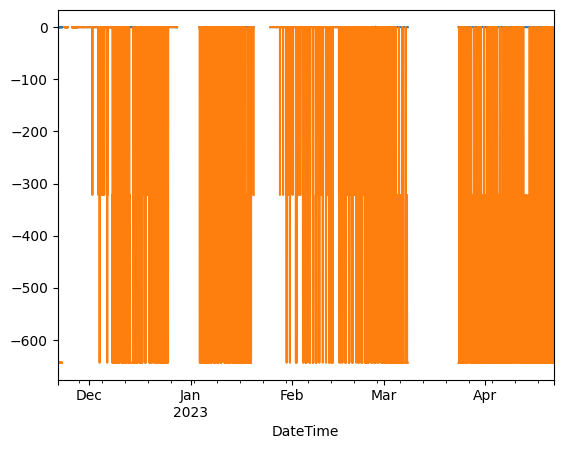

In [6]:
import numpy as np

max_temp_value = sensor_data['temperature'].max()
max_conc_value = sensor_data['measuring'].max()
sensor_data['temperature'].apply(lambda v: v/max_temp_value if not np.isnan(v) else v).plot()
sensor_data['measuring'].apply(lambda v: v/max_conc_value if not np.isnan(v) else v).plot()

## Tag concentration data according to environmental tag

In [7]:
from SensorDataAnalysisService import SensorDataAnalysisService as sensor_analysis

def tag_by_env_tag(current_tag, env_tag):
    if current_tag != 'VALID': return current_tag
    if env_tag != 'VALID': return 'INVALID_ENV'
    return 'VALID'

tags_dataframe = sensor_data[['Tag', 'Temperature Tag']]
sensor_data['Tag'] = tags_dataframe.apply(lambda df: tag_by_env_tag(df[0], df[1]), axis=1)
tags = ['MISSING','LTLL', 'GTUL', 'BADSPIKE', 'VALID', 'LTQTLE01', 'GTQTLE99', 'INVALID_ENV']
data_contabilization = sensor_analysis.count_tags(tags, sensor_data)
data_contabilization

,#,%
MISSING,6481,44.56746
LTLL,1759,12.095998
GTUL,0,0.0
BADSPIKE,573,3.940311
VALID,5259,36.164214
LTQTLE01,101,0.69454
GTQTLE99,81,0.557007
INVALID_ENV,287,1.973594
TOTAL,14542,100.0


<Axes: xlabel='DateTime'>

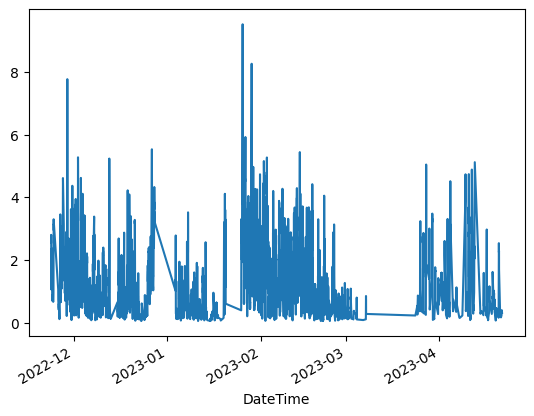

In [8]:
sensor_data[sensor_data['Tag'] == 'VALID']['measuring'].plot()

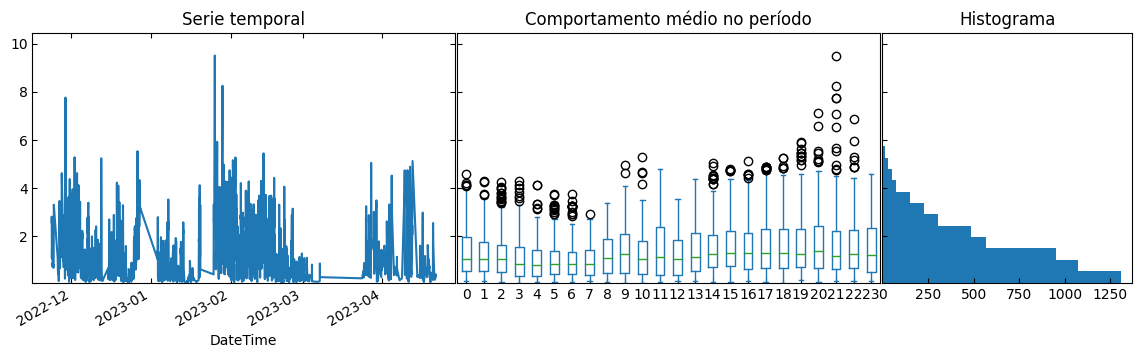

In [9]:
valid_dataframe = sensor_data[sensor_data['Tag'] == 'VALID'].drop(columns=['Tag', 'Temperature Tag'])
sensor_analysis.plot_box_hist(df=valid_dataframe, bins=20)

## Plot sensor vs. temperature

Spearmans correlation coefficient: 0.290
Samples are correlated (reject H0) p=0.000
Kendall correlation coefficient: 0.290
Samples are correlated (reject H0) p=0.000


Text(0.05, 0.9, 'Coef. de Kendall=0.196, p<0.05')

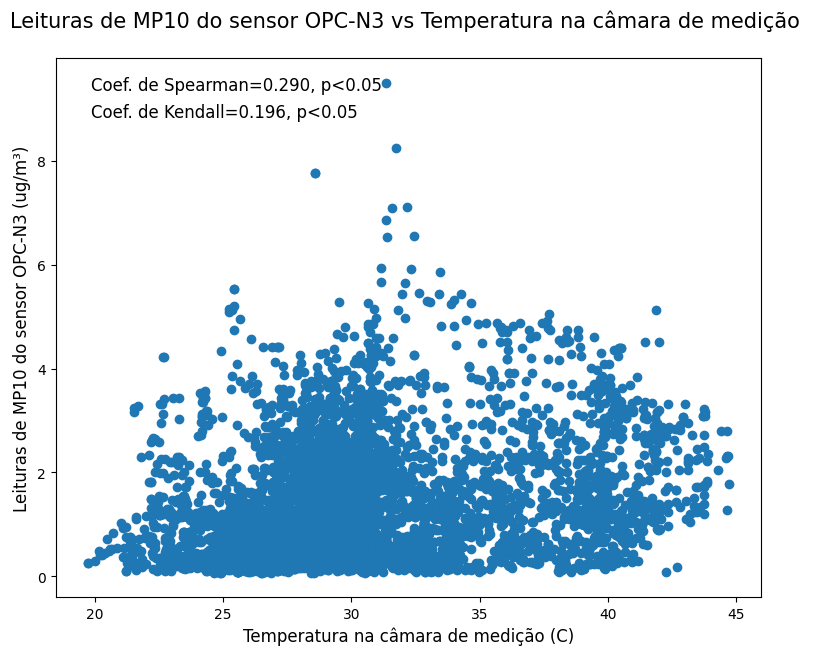

In [10]:
from scipy.stats import spearmanr
from scipy.stats import kendalltau
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(1.3*7,7))
plt.scatter(valid_dataframe['temperature'], valid_dataframe['measuring'])
plt.title('Leituras de MP10 do sensor OPC-N3 vs Temperatura na câmara de medição \n', 
          fontdict={'fontsize':15})
plt.xlabel('Temperatura na câmara de medição (C)', 
           fontsize=12)
plt.ylabel('Leituras de MP10 do sensor OPC-N3 (ug/m\N{SUPERSCRIPT THREE})', 
           fontsize=12)
coef, p = spearmanr(valid_dataframe['temperature'], valid_dataframe['measuring'], 
                    nan_policy='omit')
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)

kendall, pken = kendalltau( valid_dataframe['temperature'], valid_dataframe['measuring'], 
                            nan_policy='omit')
print('Kendall correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)
 
string = 'Coef. de Spearman=%.3f, p<0.05' % coef
plt.text(0.05, 0.95, string, horizontalalignment='left', fontsize=12,
         verticalalignment='center', transform=ax.transAxes)
string = 'Coef. de Kendall=%.3f, p<0.05' % kendall
plt.text(0.05, 0.90, string, horizontalalignment='left', fontsize=12,
         verticalalignment='center', transform=ax.transAxes)

## Remove temperature dependance

In [14]:
from sklearn.linear_model import LinearRegression

sample_dataframe = valid_dataframe[['temperature', 'measuring']].dropna()
temperature = sample_dataframe['temperature']
concentration = sample_dataframe['measuring']

# Reshape the data to have a 2D array for sklearn
X = temperature.values.reshape(-1, 1)
y = concentration.values

# Create a linear regression model
model = LinearRegression()

# Fit the model
model.fit(X, y)

# Predict concentration based on the temperature
concentration_predicted = model.predict(X)

# Remove the temperature component from the concentration
concentration_without_temperature = y - concentration_predicted

# Create a new pandas Series with the result
result_series = pd.Series(concentration_without_temperature - np.min(concentration_without_temperature), 
                            index=sample_dataframe.index, name = 'measuring no Temp')

# Print the result
print(result_series)

DateTime
2022-11-23 13:00:00    3.207380
2022-11-23 13:15:00    3.499164
2022-11-23 13:30:00    3.120038
2022-11-23 14:45:00    1.893972
2022-11-23 15:00:00    1.994882
                         ...   
2023-04-21 08:45:00    1.255510
2023-04-21 13:00:00    0.580334
2023-04-21 14:30:00    0.853405
2023-04-21 14:45:00    0.902938
2023-04-21 17:15:00    0.881824
Name: measuring no Temp, Length: 5259, dtype: float64


#### Plot the results

/var/folders/wc/_83zcrx913j1dqwg4g90kbhh0000gp/T/ipykernel_32267/2997911208.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,1,1)


Text(0.5, 1.0, 'Alphasense CO sensor concentration without temperature component vs Sensor chamber temperature \n')

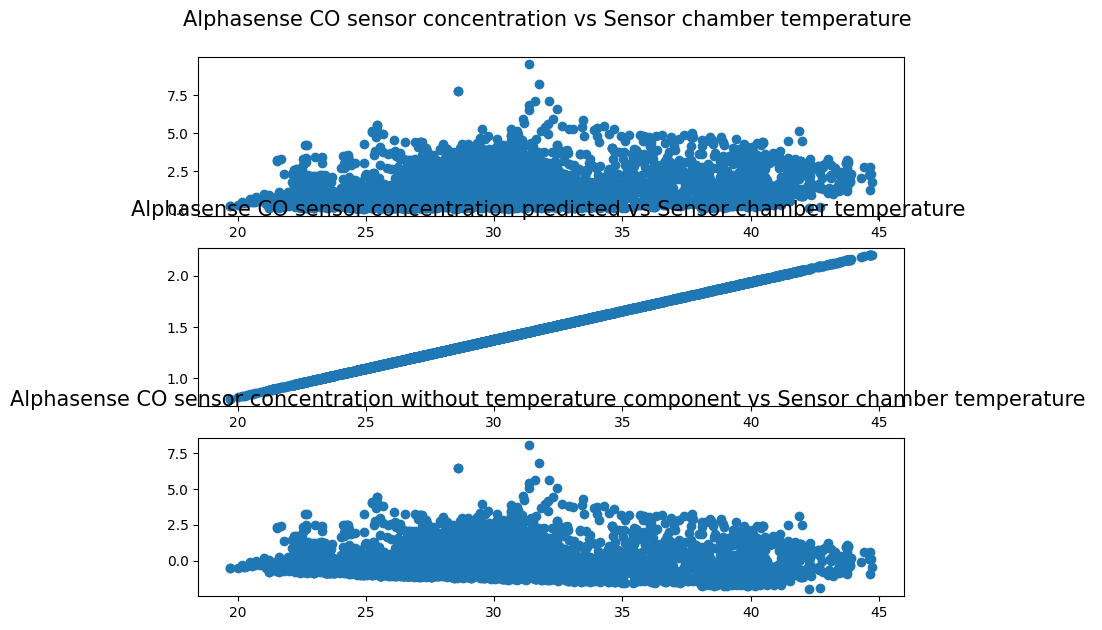

In [15]:
from scipy.stats import spearmanr
from scipy.stats import kendalltau
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(1.3*7,7))
plt.subplot(3,1,1)
plt.scatter(temperature, concentration)
plt.title('Alphasense CO sensor concentration vs Sensor chamber temperature \n', 
          fontdict={'fontsize':15})
plt.subplot(3,1,2)
plt.scatter(temperature, concentration_predicted)
plt.title('Alphasense CO sensor concentration predicted vs Sensor chamber temperature \n', 
          fontdict={'fontsize':15})
plt.subplot(3,1,3)
plt.scatter(temperature, concentration_without_temperature)
plt.title('Alphasense CO sensor concentration without temperature component vs Sensor chamber temperature \n', 
          fontdict={'fontsize':15})

#### Store concentration without temperature in dataframe

In [16]:
valid_dataframe = pd.concat([valid_dataframe,result_series], axis=1)
valid_dataframe.head()

,measuring,Hour,temperature,measuring no Temp
DateTime,,,,
2022-11-23 13:00:00,2.570,13.0,29.520,3.207380
2022-11-23 13:15:00,2.810,13.0,28.600,3.499164
2022-11-23 13:30:00,2.385,13.0,27.785,3.120038
2022-11-23 14:45:00,1.070,14.0,26.205,1.893972
2022-11-23 15:00:00,1.165,15.0,26.100,1.994882


In [17]:
valid_dataframe.head()

,measuring,Hour,temperature,measuring no Temp
DateTime,,,,
2022-11-23 13:00:00,2.570,13.0,29.520,3.207380
2022-11-23 13:15:00,2.810,13.0,28.600,3.499164
2022-11-23 13:30:00,2.385,13.0,27.785,3.120038
2022-11-23 14:45:00,1.070,14.0,26.205,1.893972
2022-11-23 15:00:00,1.165,15.0,26.100,1.994882


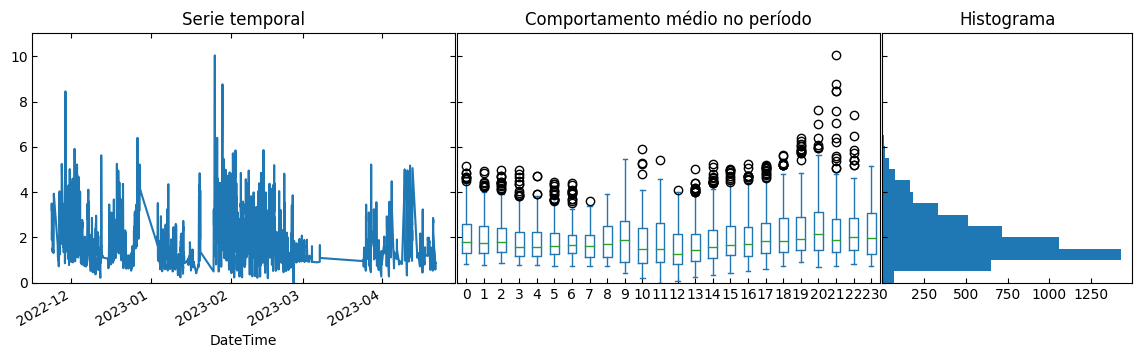

In [18]:
dataframe = valid_dataframe.drop(columns='measuring').rename(columns={'measuring no Temp': 'measuring'})
sensor_analysis.plot_box_hist(df=dataframe, bins=20)

# Resample Data

,measuring,Hour,temperature,measuring no Temp,Count
DateTime,,,,,
2022-11-23 13:30:00,2.588333,13,28.63500,3.275528,3
2022-11-23 14:30:00,1.070000,14,26.20500,1.893972,1
2022-11-23 15:30:00,1.341250,15,26.16125,2.167685,4
2022-11-23 16:30:00,1.335000,16,26.44125,2.145674,4
2022-11-23 17:30:00,NaN,17,NaN,NaN,0


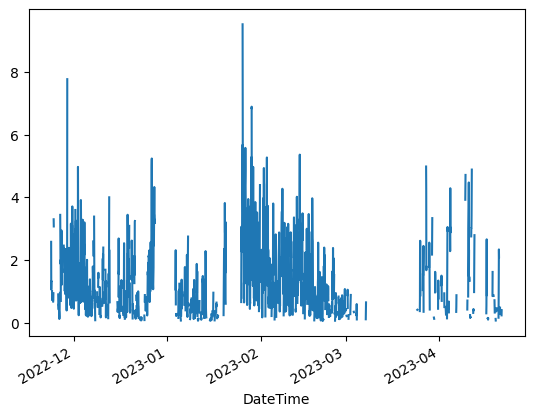

In [19]:
data_1HR = valid_dataframe.resample('H').mean()
data_1HR['Hour'] = data_1HR.index.hour
data_1HR['Count'] = (valid_dataframe['measuring'].resample('H').count())
data_1HR.index = data_1HR.index.map(lambda t: t.replace(minute=30, second=0))
data_1HR['measuring'].plot()
data_1HR.head()

#### Tag hourly data according to the number of samples in an hour
At least 3 samples must be valid in an hour (75 %) for the hourly data be considered as valid

<Axes: xlabel='DateTime'>

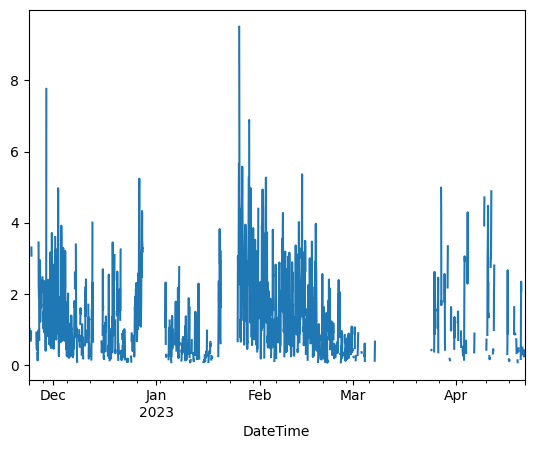

In [20]:
data_1HR['Tag'] = (data_1HR['Count'].map(lambda c: 'VALID' if c >= 3 else 'LOWSAMPLES'))
data_1HR['measuring'].resample('H').mean().plot()

#### Valid data contabilization

In [21]:
tags = ['LOWSAMPLES','VALID'] 
data_contabilization = sensor_analysis.count_tags(tags, data_1HR)
data_contabilization

,#,%
LOWSAMPLES,2375,66.322256
VALID,1206,33.677744
TOTAL,3581,100.0


In [22]:
valid_data_1HR = data_1HR[data_1HR['Tag'] == 'VALID']

# Save Data

In [23]:
import os

output_directory_path = 'data/output/'
processing_directory_path = '../data-processing/input/'
valid_filename = '_and_temp_valid.csv'
valid_filename_1HR = '_and_temp_valid_1HR.csv'

valid_1HR_file_path_output = output_directory_path + SENSOR_NAME + valid_filename_1HR
valid_file_path_output = output_directory_path + SENSOR_NAME + valid_filename

valid_processing_1HR_file_path = processing_directory_path + SENSOR_NAME + valid_filename_1HR
valid_processing_file_path = processing_directory_path + SENSOR_NAME + valid_filename

if not os.path.exists(output_directory_path):
    os.makedirs(output_directory_path)

if not os.path.exists(processing_directory_path):
    os.makedirs(processing_directory_path)

valid_dataframe.to_csv(valid_file_path_output)
valid_data_1HR.to_csv(valid_1HR_file_path_output)

valid_dataframe.to_csv(valid_processing_file_path)
valid_data_1HR.to_csv(valid_processing_1HR_file_path)